In [1]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.5.4

DEPRECATION: pytorch-lightning 1.5.4 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.5.4 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

/pasteur/u/aunell/miniconda3/envs/dino2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [3]:
# # download data
# root = "."
# SimpleOxfordPetDataset.download(root)

In [4]:

# from torch.utils.data import Subset
# # init train, val, test sets
# train_dataset = SimpleOxfordPetDataset(root, "train")
# valid_dataset = SimpleOxfordPetDataset(root, "valid")
# test_dataset = SimpleOxfordPetDataset(root, "test")
# train_dataset = Subset(train_dataset, indices=range(80))
# test_dataset = Subset(test_dataset, indices=range(80))
# valid_dataset = Subset(valid_dataset, indices=range(80))

# print(f"Train size: {len(train_dataset)}")
# print(f"Valid size: {len(valid_dataset)}")
# print(f"Test size: {len(test_dataset)}")
# print(type(train_dataset))
# n_cpu = os.cpu_count()
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
# valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

In [57]:
from torch.utils.data import Dataset
from PIL import Image
import os
import pickle
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, ignore_dir, feature_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.ignore_dir = ignore_dir
        self.feature_dir = feature_dir
        self.transform = transform

        self.img_names = sorted(os.listdir(img_dir))
        self.mask_names = sorted(os.listdir(mask_dir))
        self.ignore_names = sorted(os.listdir(ignore_dir))
        self.feature_names = sorted(os.listdir(feature_dir))

    def __len__(self):
        print('self image names', self.img_names)
        return len(self.img_names)

    def __getitem__(self, idx):
        print('idx', idx)
        feature_path = os.path.join(self.feature_dir, self.feature_names[idx])
        features = torch.load(feature_path).transpose(2,0,1)

        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = Image.open(img_path).convert('RGB')
        img = np.array(img.resize((img.width//14, img.height//14)))
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])
        # mask = np.array(Image.open(mask_path).convert("L"))/255.0
        # mask=mask[np.newaxis, :, :]
        mask = np.array(Image.open(mask_path).convert("L").resize((features.shape[2], features.shape[1])))/255.0
        mask=mask[np.newaxis, :, :]
        ignore_path = os.path.join(self.ignore_dir, self.ignore_names[idx])
        with open(ignore_path, 'rb') as f:
            ignore_coords = pickle.load(f)


        return {'image': img, 'features': features, 'mask': mask, 'ignore_coords': ignore_coords}

In [58]:
img_dir = '/pasteur/u/aunell/cryoViT/data/sample_data/original'
mask_dir = '/pasteur/u/aunell/cryoViT/data/training/mask'
ignore_dir = '/pasteur/u/aunell/cryoViT/data/training/ignore'
feature_dir = '/pasteur/u/aunell/cryoViT/data/training/features'
n_cpu = os.cpu_count()
print(n_cpu)
# Create the dataset
train_dataset = SegmentationDataset(img_dir, mask_dir, ignore_dir, feature_dir)
valid_dataset = SegmentationDataset(img_dir, mask_dir, ignore_dir, feature_dir)
test_dataset = SegmentationDataset(img_dir, mask_dir, ignore_dir, feature_dir)
print(f"Train size: {len(train_dataset)}")
print(train_dataset[0]['features'].shape)
print(type(train_dataset[0]['features']))
print(train_dataset[0]['mask'].shape)
# Create the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

72
self image names ['image_test_L25_001_16.png', 'image_test_L25_002_16.png', 'image_test_L25_003_16.png', 'image_test_L25_004_16.png', 'image_test_L25_005_16.png', 'image_test_L25_006_16.png', 'image_test_L25_007_16.png']
Train size: 7
idx 0
(1536, 215, 176)
idx 0
<class 'numpy.ndarray'>
idx 0
(1, 215, 176)
self image names ['image_test_L25_001_16.png', 'image_test_L25_002_16.png', 'image_test_L25_003_16.png', 'image_test_L25_004_16.png', 'image_test_L25_005_16.png', 'image_test_L25_006_16.png', 'image_test_L25_007_16.png']
self image names ['image_test_L25_001_16.png', 'image_test_L25_002_16.png', 'image_test_L25_003_16.png', 'image_test_L25_004_16.png', 'image_test_L25_005_16.png', 'image_test_L25_006_16.png', 'image_test_L25_007_16.png']


idx 0
(1, 215, 176)
112992


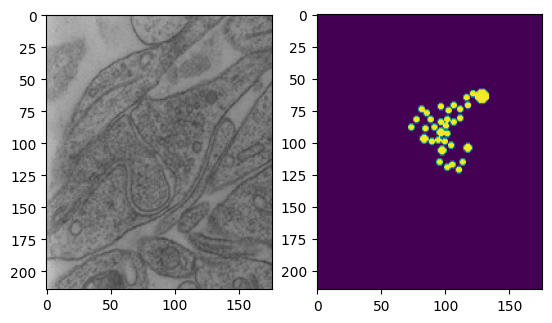

idx 1


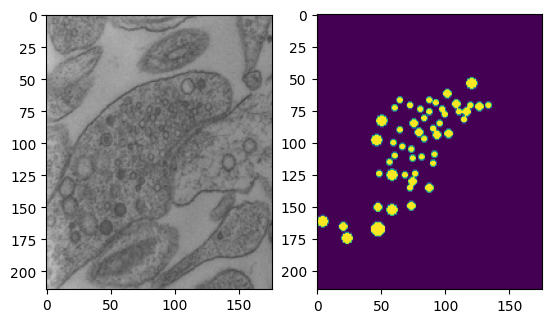

idx 2


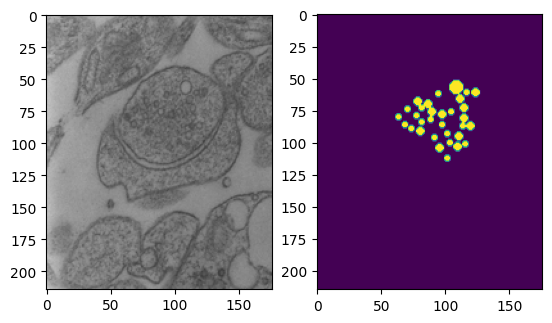

In [60]:
# lets look at some samples
sample = train_dataset[0]
print(sample['mask'].shape)
print(sample['image'].size)
plt.subplot(1,2,1)
plt.imshow(sample["image"]) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[1]
plt.subplot(1,2,1)
plt.imshow(sample["image"]) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[2]
plt.subplot(1,2,1)
plt.imshow(sample["image"]) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [39]:
import numpy as np
class PetModel2(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        print('init')
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        print('forward')
        # normalize image here
        # image = (image - self.mean) / self.std
        image=torch.tensor(image).float().cuda()
        mask = self.model(image)
        return mask
    
    def calculate_loss(self, image, mask, ignore_coords):
        print('calculating loss')
        logits_mask = self.forward(image)

        # Create a mask of the same size as the image, with 1s at the coordinates to ignore and 0s elsewhere
        ignore_mask = torch.zeros_like(mask).cuda()
        for x, y in ignore_coords:
            ignore_mask[x, y] = 1

        # Apply the ignore mask to the logits_mask and mask
        logits_mask = logits_mask * (1 - ignore_mask)
        mask = mask * (1 - ignore_mask)

        # Calculate the loss
        loss = self.loss_fn(logits_mask, mask)

        return loss, logits_mask
    
    def shared_step(self, batch, stage):
        print('shared step')
        image = batch["features"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        image=image.permute(0, 3, 1, 2)
        b,c, h, w = image.shape
        pad_height = 32- (h % 32)
        pad_width = 32- (w % 32)
        image = np.pad(image.cpu(), ((0, 0), (0, 0), (0, pad_height), (0, pad_width)), mode='constant').cuda()
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0 #TODO

        # logits_mask = self.forward(image)
        # # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        # loss = self.loss_fn(logits_mask, mask)
        loss, logits_mask= self.calculate_loss(image, mask, batch["ignore_coords"])

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        print('outputs', outputs)
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [69]:
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [70]:
model = PetModel("FPN", "resnet34", in_channels=1536, out_classes=1)

In [1]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=1,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=train_dataloader,
)

NameError: name 'pl' is not defined

In [ ]:
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_dataset_iou': 0.7618280649185181,
  'valid_per_image_iou': 0.744632363319397}]


In [18]:

# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
[{'test_dataset_iou': 0.7622432708740234,
  'test_per_image_iou': 0.7563651204109192}]


## Result Visualization

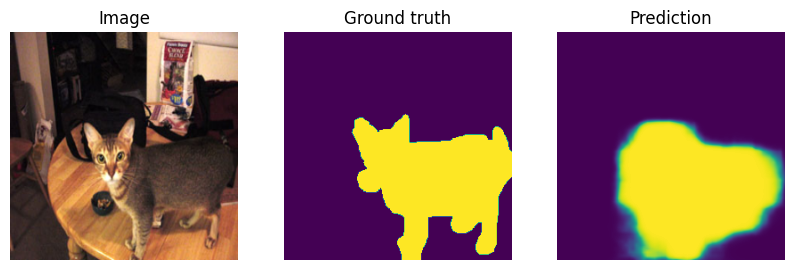

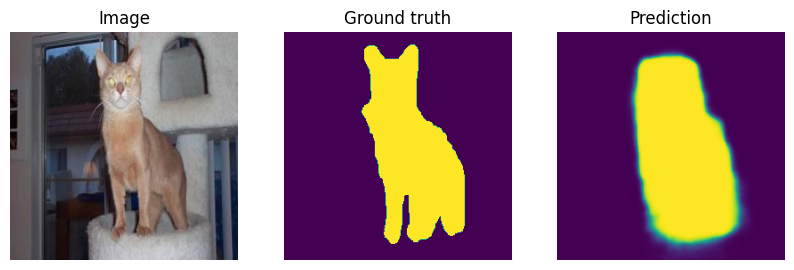

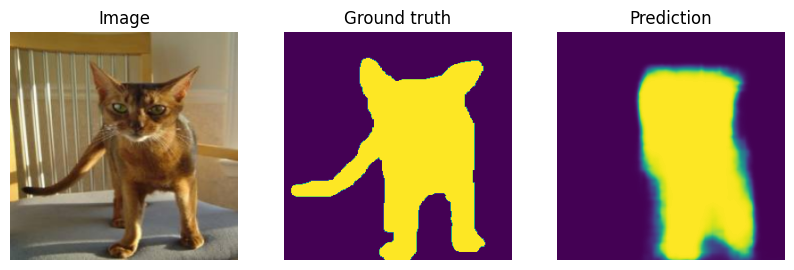

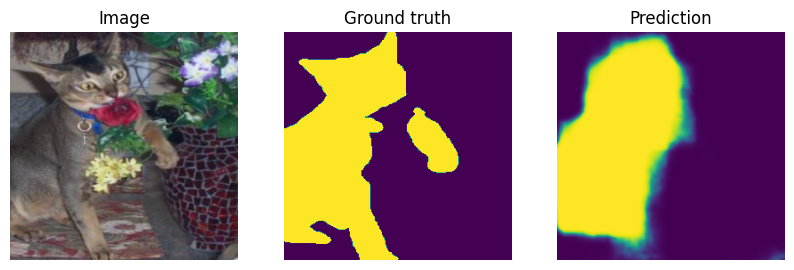

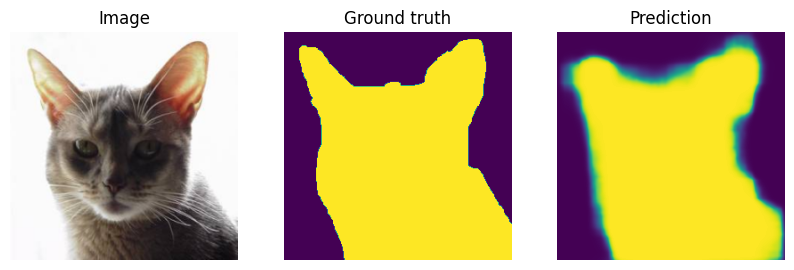

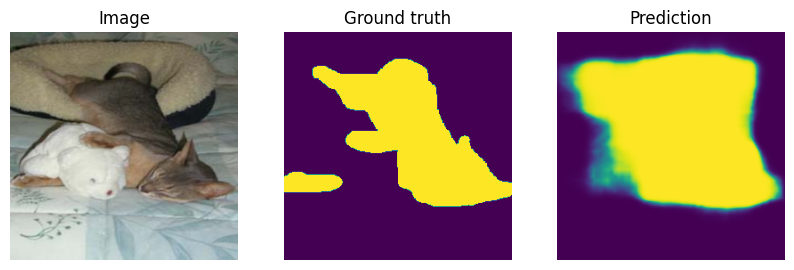

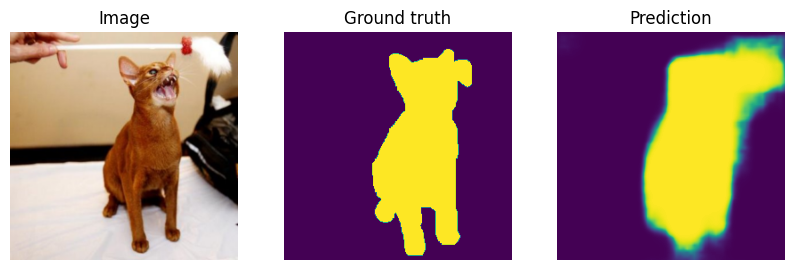

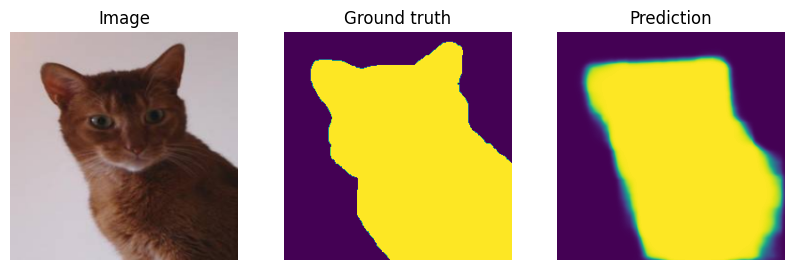

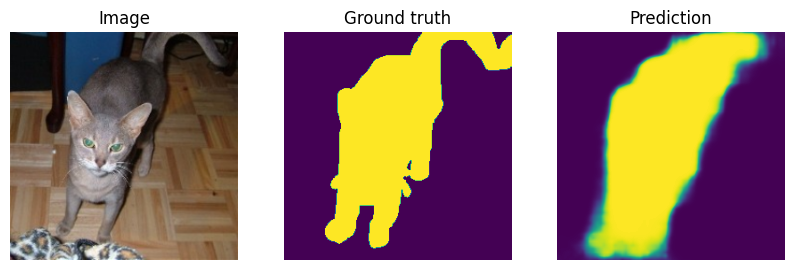

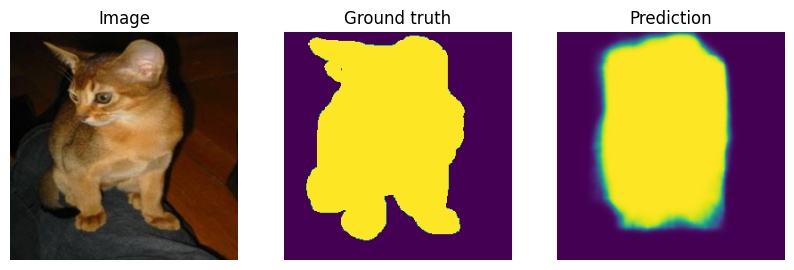

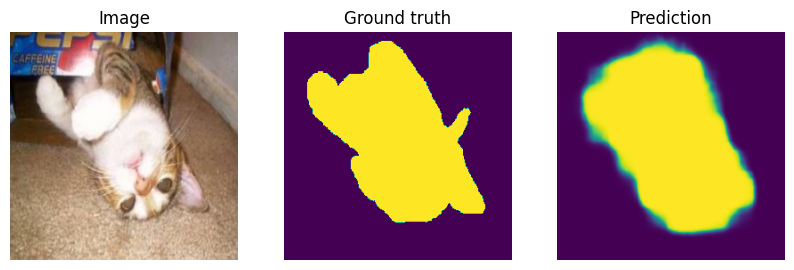

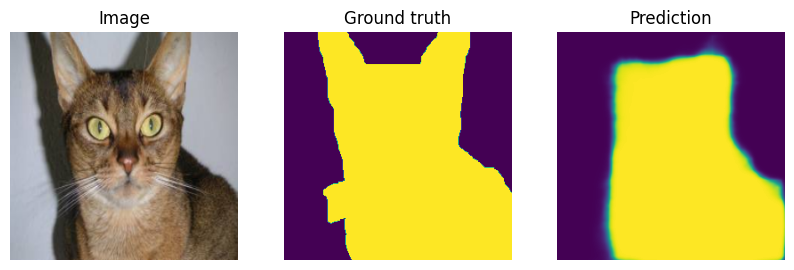

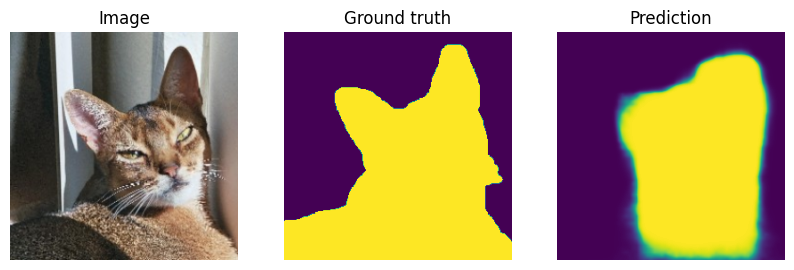

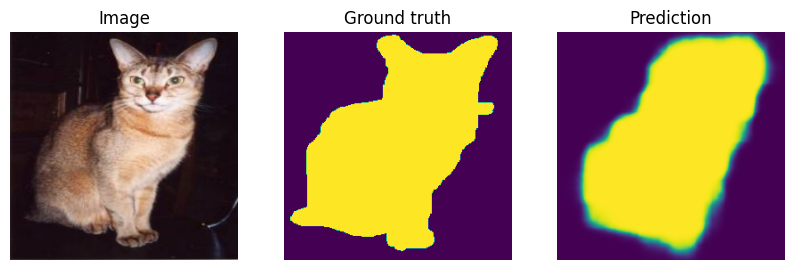

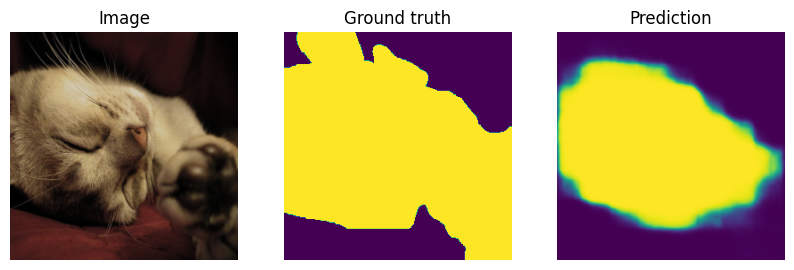

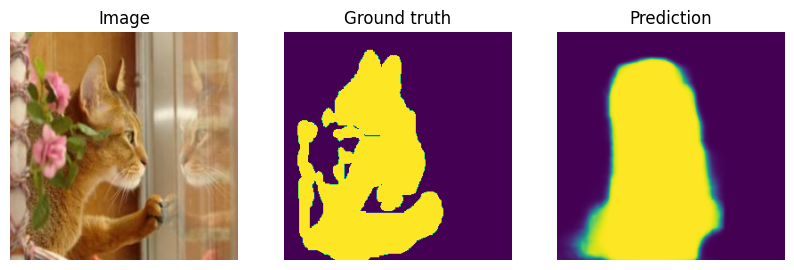

In [19]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()